In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'serif' : 'Computer Modern Roman',
        'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['figure.figsize'] = [2*3.54, 3.54]

from systems import DoubleIntegrator, DoubleIntegratorWithPerturbations

from nnpolicy import NNPolicy
import torch

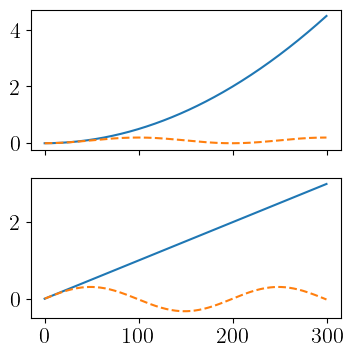

In [5]:
dt = 0.01
N = 300

# System
system = DoubleIntegrator(dt)
system_perturb = DoubleIntegratorWithPerturbations(dt)

system.state = np.zeros(2)
system_perturb.state = np.zeros(2)
state_list = []
state_perturb_list = []

for i in range(N):
    action = 1.0
    result = system.step(action)
    result_perturb = system_perturb.step(action)
    state_list.append(system.state)
    state_perturb_list.append(system_perturb.state)
    
fig, ax = plt.subplots(2, 1, figsize=(4, 4), sharex=True)
state_list = np.array(state_list)
state_perturb_list = np.array(state_perturb_list)
ax[0].plot(state_list[:, 0], '-', label='x')
ax[0].plot(state_perturb_list[:, 0], '--', label='x with perturbations')
ax[1].plot(state_list[:, 1], '-', label='\dot{x}')    
ax[1].plot(state_perturb_list[:, 1], '--', label='\dot{x} with perturbations')


In [6]:
net_arch = [(4, 24), (24, 48), (48, 24), (24, 1)] # NN policy
policy = NNPolicy(net_arch)

# load weights
policy.load_state_dict(torch.load('models/model_weights.pth'))



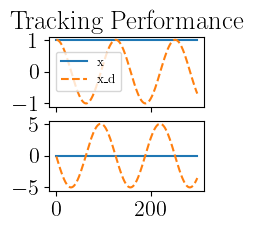

In [10]:
state_list = []
des_traj_list = []

des_traj_pos = lambda t: np.cos(t*0.05)
pos_des = [des_traj_pos(i) for i in range(N)]
des_traj_vel = np.zeros(N)
for i in range(N-1):
    des_traj_vel[i] = (pos_des[i+1] - pos_des[i])/dt

x0 = np.array([des_traj_pos(0), des_traj_vel[0]])
system.state = x0.copy()

for i in range(N-1):
    state_des = np.array([ des_traj_pos(i), des_traj_vel[i] ])
    action = policy.predict(system_perturb.state, state_des)
    action_np = action.detach().numpy()
    result = system_perturb.step(action_np.squeeze())
    next_state = result[0]
    state_list.append(system.state)
    des_traj_list.append(state_des)
    
state_list = np.array(state_list)
des_traj_list = np.array(des_traj_list)

fig, ax = plt.subplots(2, 1, figsize=(2, 2), sharex=True)
ax[0].set_title('Tracking Performance')
ax[0].plot(state_list[:, 0], '-', label='x')
ax[0].plot(des_traj_list[:, 0], '--', label='x_d')
ax[0].legend(fontsize='xx-small')

ax[1].plot(state_list[:, 1], '-', label='\dot{x}')
ax[1].plot(des_traj_list[:, 1], '--', label='\dot{x}_d')

Text(0, 0.5, 'Average reward')

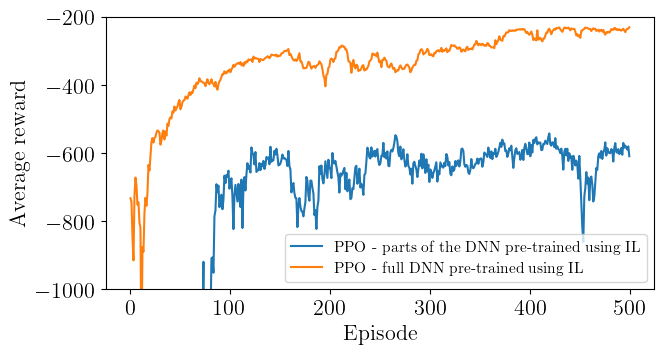

In [35]:

# path = 'PPO_preTrained/DoubleIntegratorWithPerturbations/PPO_DoubleIntegratorWithPerturbations_0_0.pth'
directory = 'PPO_preTrained/DoubleIntegratorWithPerturbations/'
path_NN = directory + '/PPO_DoubleIntegratorWithPerturbations_0_0.pth'
from PPO import ActorCritic
import matplotlib.pyplot as plt
import torch
state_dim = 2
action_dim = 1
has_continuous_action_space = True
action_std_init = 0.6
policy_PPO = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init)

# load weights
policy_PPO.load_state_dict(torch.load(path_NN))

average_reward_partial_IL = np.load(directory + 'average_reward_partial_IL.npy')
average_reward_full_IL = np.load(directory + 'average_reward_full_IL.npy')

# plot as a moving average
window = 1
# exponential moving average
ma_vec_partial_IL = np.convolve(average_reward_partial_IL, np.ones(window)/window, mode='valid')
ma_vec_full_IL = np.convolve(average_reward_full_IL, np.ones(window)/window, mode='valid')
# shadows

plt.figure()
plt.plot(ma_vec_partial_IL, label='PPO - parts of the DNN pre-trained using IL')
plt.plot(ma_vec_full_IL, label='PPO - full DNN pre-trained using IL')
plt.ylim(-1000, -200)
plt.legend(fontsize='x-small', loc='lower right')
# plot the shades
plt.xlabel('Episode')
plt.ylabel('Average reward')


In [ ]:
# Multiple traj regulation:
nb_traj = 10
fig, ax = plt.subplots(2, 1, figsize=(2, 2), sharex=True)
for i in range(nb_traj):
    system_perturb.reset()
    state_list = []
    for _ in range(N):
        state_des = np.zeros(2)
        input_tensor = torch.FloatTensor(system_perturb.state).unsqueeze(0)
        result = policy_PPO.act(input_tensor)
        action = result[0].detach().numpy()
        result = system_perturb.step(action.squeeze())
        next_state = result[0]
        state_list.append(system_perturb.state)
        
    state_list = np.array(state_list)
    ax[0].plot(state_list[:, 0], '-', label='x')
    ax[1].plot(state_list[:, 1], '-', label='\dot{x}')    
    ax[0].set_title('Regulation')
    

